# Carregar e testar modelo

In [67]:
def predict_img(img_path):
    img = load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    
    img_array = img_to_array(img)
    
    img_batch = np.expand_dims(img_array, axis=0)
    for y in img_batch[[0][0]]:
        y /= 255

    predict = model.predict(img_batch, verbose=0)
    rounded_result = int(np.round(predict[0]))
    result = int(predict[0] * 100)
    
    labels = ['Tumor', 'Saudável']
    labeled_result = labels[rounded_result]
    
    if predict > 0.5:
        print(f'Resultado: {labeled_result}, com {result}% de certeza.')
    else:
        print(f'Resultado: {labeled_result}, com {100 - result}% de certeza.')

In [68]:
model = tf.keras.models.load_model('Models/BrainTumorDetectorModel')

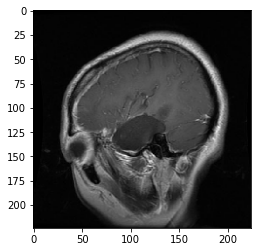

Resultado: Tumor, com 100% de certeza.


In [70]:
# Inserir caminho do arquivo de imagem.
predict_img('ConjuntoTeste/Cancer (100).jpg')

# Configurações

### Importar pacotes

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import random
import os
import shutil
import sklearn.utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import sys

%matplotlib inline

### Preparar datasets

In [2]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [3]:
train_path = 'Datasets/brain-tumor-dataset/Brain Tumor Data Set/train/'
test_path = 'Datasets/brain-tumor-dataset/Brain Tumor Data Set/test/'

train_batches = data_gen.flow_from_directory(directory=train_path, target_size=(224, 224), class_mode='binary',subset='training')
valid_batches = data_gen.flow_from_directory(directory=train_path, target_size=(224, 224), class_mode='binary',subset='validation')
test_batches = data_gen.flow_from_directory(directory=test_path, target_size=(224, 224), class_mode='binary', shuffle=False)

train_batches.class_indices

Found 3636 images belonging to 2 classes.
Found 908 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


{'Brain Tumor': 0, 'Healthy': 1}

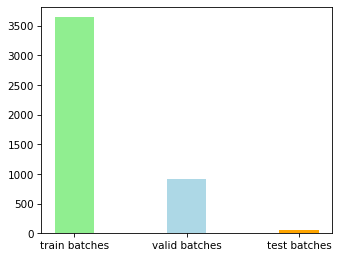

In [65]:
plt.figure(figsize=(5, 4), dpi=75)

data = [train_batches, valid_batches, test_batches]

xdata = ['train batches', 'valid batches', 'test batches']
ydata = [x.n for x in data]

colors = ['lightgreen', 'lightblue', 'orange']
plt.bar(xdata, ydata, color=colors, width=0.35)

plt.show()

### Criar o modelo

In [102]:
model = Sequential([
    
    Conv2D(input_shape=(224, 224, 3), filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               23888000  
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [103]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Treinamento

In [104]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=5,
    verbose=2
)

Epoch 1/5
114/114 - 123s - loss: 0.5433 - accuracy: 0.7591 - val_loss: 0.2756 - val_accuracy: 0.8921
Epoch 2/5
114/114 - 119s - loss: 0.2395 - accuracy: 0.9076 - val_loss: 0.1102 - val_accuracy: 0.9593
Epoch 3/5
114/114 - 120s - loss: 0.1293 - accuracy: 0.9546 - val_loss: 0.0599 - val_accuracy: 0.9824
Epoch 4/5
114/114 - 120s - loss: 0.0704 - accuracy: 0.9766 - val_loss: 0.0395 - val_accuracy: 0.9857
Epoch 5/5
114/114 - 120s - loss: 0.0597 - accuracy: 0.9816 - val_loss: 0.0291 - val_accuracy: 0.9934


In [105]:
predictions = model.predict(test_batches, verbose=0)

In [ ]:
for i in predictions:
    x = i * 100
    print(x)

### Validação

In [109]:
###Official function from Sklearn###

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28  0]
 [ 0 28]]


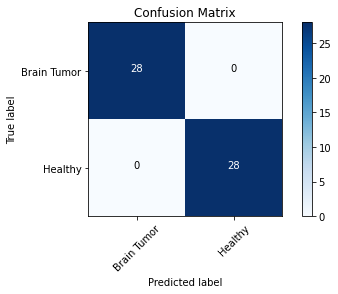

In [133]:
cm = confusion_matrix(test_batches.classes, np.round(predictions))

plot_confusion_matrix(cm, classes=test_batches.class_indices, title='Confusion Matrix')

### Salvar o modelo

In [135]:
model.save(filepath='Models/BrainTumorDetectorModel')

INFO:tensorflow:Assets written to: Models/BrainTumorDetectorModel\assets
